## 1.- Data preparation:

### Aux function to grow nan areas in space for DataArrays

In [ ]:
from scipy import signal

def buffer_nans(da, kn):
    k = np.zeros((kn,kn))
    k[kn//2,kn//2] = 1

    arr = da.values
    mask = np.ones(arr.shape).astype(np.float32)

    for i in range(arr.shape[0]):
        mask[i,:,:] = signal.convolve2d(arr[i,:,:], k, boundary='fill', mode='same')

    return da.where(~np.isnan(mask))

### Import libraries and load dataset

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

### Compute masking using the blue band

In [ ]:
ds = xr.open_dataset("Murrumbidgee_near_Bundure__MUR_B3.nc")

ds = ds.isel(x=slice(400,800), y=slice(0,400))

In [ ]:
blue = ds.nbart_blue.astype(np.float32) / 1e4

# 1.- Filter reflectances greater than 0.5 
blue = blue.where(blue<.5)

# 2.- Filter reflectances with difference to lower quartile larger than 0.05 => (0.07)
blue = blue.where((blue - blue.quantile(0.25, dim='time'))<.07)

# 3.- Grow a 5x5 buffer around NaN pixels 
blue = buffer_nans(blue, 5)

# 4.- Discard frames with more than 25% missing pixels
blue = blue.isel(time=(blue.count(dim=('x','y'))/(400*400))>.25)

blue.isel(time=3).plot()

### Apply mask to all the other bands and save for PCA training

In [ ]:
for band_name in ds:
    band = ds[band_name].astype(np.float32) / 1e4
    
    # 1. Apply blue mask
    band = band.sel(time=blue.time).where(~np.isnan(blue))

    # 2.- Interpolate NaNs over time linearly
    band = band.interpolate_na(dim='time')

    # 3.- Interpolate NaNs at the start and end using nearest neighbor
    band = band.interpolate_na(dim='time', method='nearest', fill_value='extrapolate')

    # 4.- Apply median rolling filter along time (window=3)
    band = band.rolling(time=3, min_periods=1).median()
    
    np.save(band_name, band)

### Create data stack

In [3]:
stack = np.empty((0,400,400))

"""
for fname in ["nbart_red.npy","nbart_green.npy","nbart_blue.npy",
              "nbart_nir_1.npy","nbart_nir_2.npy","nbart_swir_2.npy",
              "nbart_swir_3.npy"]:
"""
for fname in ["nbart_red.npy","nbart_green.npy","nbart_blue.npy"]:
    
    band = np.load(fname)
    stack = np.append(stack, band, axis=0)
    
stack = stack.reshape(stack.shape[0], -1)
    
stack.shape

(315, 160000)

### PCA decomposition

((315, 12), (12, 160000))

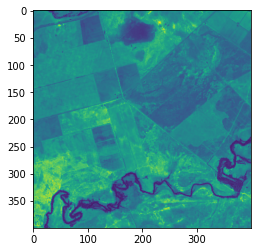

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=12).fit(stack)
coeffs = pca.transform(stack)
comps = pca.components_

plt.imshow(comps[0].reshape(400,400))
coeffs.shape, comps.shape

### NN decomposition

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)  
print(device)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 315, bias=False)  # 6*6 from image dimension
        self.fc2 = nn.Linear(1, 160000, bias=False)

    def forward(self, x):
        coeffs = self.fc1(x)
        base = self.fc2(x)
        return torch.mul(coeffs.view(315, 1), base.view(1, 160000))

cuda:0


In [16]:
def nan_mse_loss(output, target):
    loss = torch.mean((output[target != target] - target[target != target])**2)
    return loss

In [ ]:
input = torch.ones(1, device=device)
criterion = nn.MSELoss()

target = torch.from_numpy(stack-np.mean(stack, axis=0)).float().to(device)

for i in range(6):
    print(i)
    net = Net()
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    for j in range(10000):
        # training loop:
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()    # Does the update

        if j % 1000 == 0:
            loss = criterion(output, target)
            print(j, loss)
            
    params = list(net.parameters())
    coeffs = params[0].cpu().detach().numpy()
    base = params[1].cpu().detach().numpy()
    print("Range:", base.max()-base.min(), "QRes:", (base.max()-base.min())/255)
    
    offset = base.min()
    scale = 1/(base.max()-base.min())
    nbase = (base-offset)*scale
    print("NRange:", nbase.max(), nbase.min())
    
    qbase = np.rint(nbase*255).astype(np.uint8)
    
    rbase = offset + ((qbase.astype(np.float32)/255)/scale)
    print("QError:", np.mean(np.square(rbase-base)))
    
    np.save(f"q_coeffs{i:02d}", coeffs)
    np.save(f"q_offscale{i:02d}", np.array([offset,scale]))
    np.save(f"q_base{i:02d}", base)
    
    residual = target.cpu().detach().numpy() - coeffs*rbase.reshape(1,-1)
    target = torch.from_numpy(residual).to(device)

0
0 tensor(0.1069, device='cuda:0', grad_fn=<MseLossBackward>)
1000 tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)
2000 tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward>)
3000 tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward>)
4000 tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)
5000 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
6000 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
7000 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
8000 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
9000 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Range: 0.42428577 QRes: 0.0016638657625983743
NRange: 1.0 0.0
QError: 2.3006352e-07
Q2Error: 9.2712185e-07
1
0 tensor(0.1011, device='cuda:0', grad_fn=<MseLossBackward>)
1000 tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)
2000 tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)
3000 tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)

In [31]:
(coeffs*qbase.reshape(1,-1)).shape

(315, 160000)

In [ ]:
f, axarr = plt.subplots(6,1, figsize=(6,40))

for i in range(6):
    cmp = np.load(f"q_base{i:02d}.npy")
    print(cmp.min(), cmp.max(), cmp.std())
    axarr[i].imshow(cmp)

In [69]:
params = list(net.parameters())

coeffs = params[0].cpu().detach().numpy()
base = params[1].cpu().detach().numpy().reshape((400,400))

coeffs.shape, base.shape

((315, 1), (400, 400))

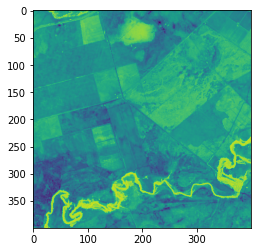

In [70]:
plt.imshow(base)

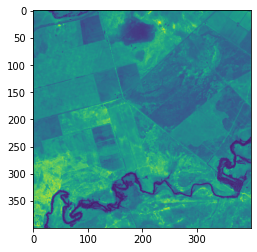

In [71]:
output = net(input)

plt.imshow(output.cpu().detach().numpy()[10].reshape(400,400))

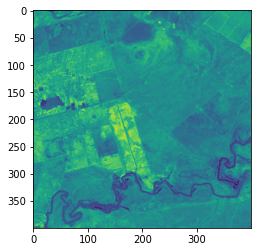

In [77]:
zm_stack = stack-np.mean(stack, axis=0)

plt.imshow(zm_stack[10].reshape(400,400))

In [59]:
zm_stack.std(), out.std()

(0.035787000940145405, 0.00088487344)